In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from env import host, username, password

import numpy as np
from matplotlib import cm
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import learning_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
import warnings
warnings.filterwarnings("ignore")



In [2]:
def get_connection(db, user=username, host=host, password=password):
    
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def new_zillow_data():
   
    sql_query = """select prop.parcelid
        , pred.logerror
        , bathroomcnt
        , bedroomcnt
        , calculatedfinishedsquarefeet
        , fips
        , latitude
        , longitude
        , lotsizesquarefeet
        , regionidcity
        , regionidcounty
        , regionidzip
        , yearbuilt
        , structuretaxvaluedollarcnt
        , taxvaluedollarcnt
        , landtaxvaluedollarcnt
        , taxamount
        from properties_2017 prop
    inner join predictions_2017 pred on prop.parcelid = pred.parcelid
    where propertylandusetypeid = 261;

                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop_duplicates(subset=['parcelid'],keep = 'last')
    return df

In [3]:
df = new_zillow_data()
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,1286.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,2061.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1286.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,3101.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,47019.0,3101.0,96293.0,1950.0,276684.0,773303.0,496619.0,9516.26


In [4]:
df=df.dropna()

In [5]:
counties = pd.get_dummies(df.fips)
counties.columns = ['la','orange','ventura']
df = pd.concat([df,counties],axis = 1)
df = df.drop(columns=['fips','regionidcounty'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50799 entries, 0 to 52441
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50799 non-null  int64  
 1   logerror                      50799 non-null  float64
 2   bathroomcnt                   50799 non-null  float64
 3   bedroomcnt                    50799 non-null  float64
 4   calculatedfinishedsquarefeet  50799 non-null  float64
 5   latitude                      50799 non-null  float64
 6   longitude                     50799 non-null  float64
 7   lotsizesquarefeet             50799 non-null  float64
 8   regionidcity                  50799 non-null  float64
 9   regionidzip                   50799 non-null  float64
 10  yearbuilt                     50799 non-null  float64
 11  structuretaxvaluedollarcnt    50799 non-null  float64
 12  taxvaluedollarcnt             50799 non-null  float64
 13  l

In [7]:
df['age'] = 2017 - df.yearbuilt
df['acres'] = df.lotsizesquarefeet/43560
df['land_cost_per_sqf'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
df['structure_cost_per_sqf'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
df['tax_rate'] = df.taxamount/df.taxvaluedollarcnt
df = df.drop(columns=['taxamount','taxvaluedollarcnt'])

In [8]:
df['bed_bath'] = df.bedroomcnt/df.bathroomcnt

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50799 entries, 0 to 52441
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50799 non-null  int64  
 1   logerror                      50799 non-null  float64
 2   bathroomcnt                   50799 non-null  float64
 3   bedroomcnt                    50799 non-null  float64
 4   calculatedfinishedsquarefeet  50799 non-null  float64
 5   latitude                      50799 non-null  float64
 6   longitude                     50799 non-null  float64
 7   lotsizesquarefeet             50799 non-null  float64
 8   regionidcity                  50799 non-null  float64
 9   regionidzip                   50799 non-null  float64
 10  yearbuilt                     50799 non-null  float64
 11  structuretaxvaluedollarcnt    50799 non-null  float64
 12  landtaxvaluedollarcnt         50799 non-null  float64
 13  l

In [9]:
df.columns = ['parcelid','logerror','bed','bath','sq_feet','latitude','longitude','lot_size','city_id','zip','year','home_value'
             ,'land_value','la','orange','ventura','age','acres','land_cost/sqf','home_cost/sqf','tax_rate','bed_bath_ratio']




In [10]:



continuous=['sq_feet','latitude','longitude','home_value','land_value','acres','land_cost/sqf','home_cost/sqf','tax_rate']




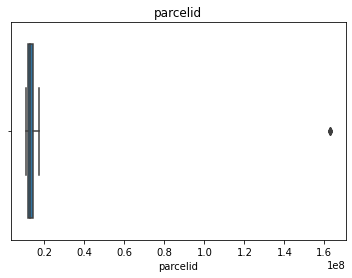

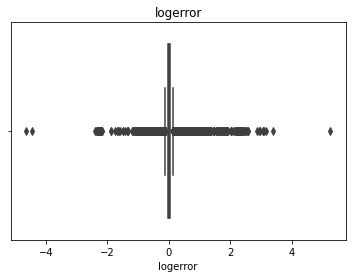

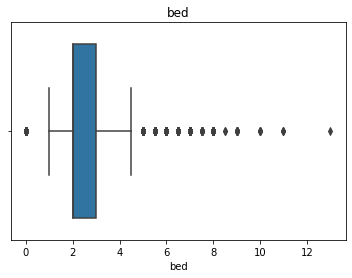

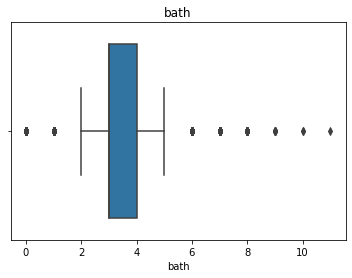

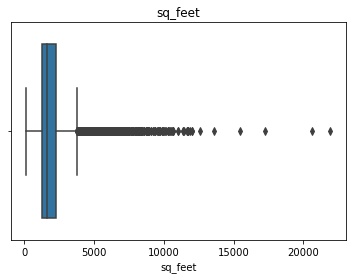

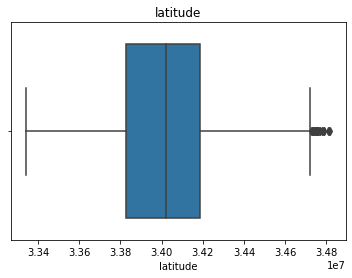

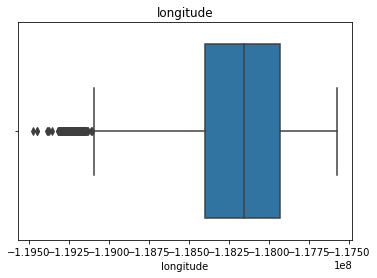

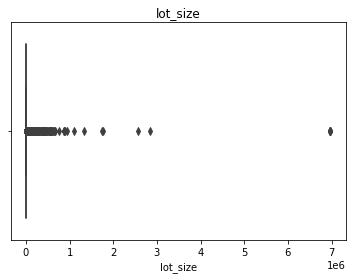

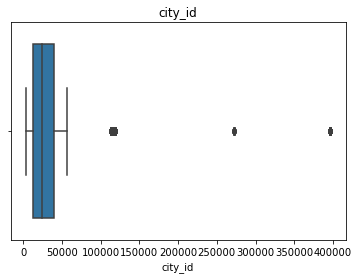

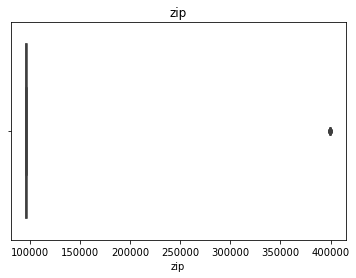

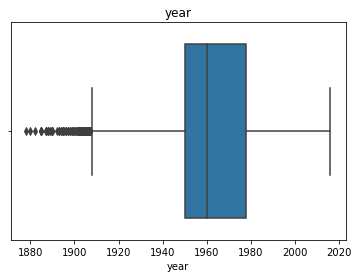

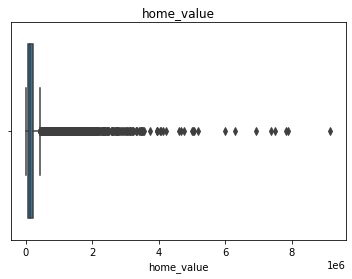

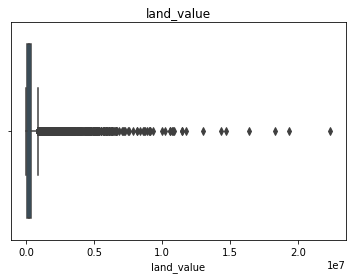

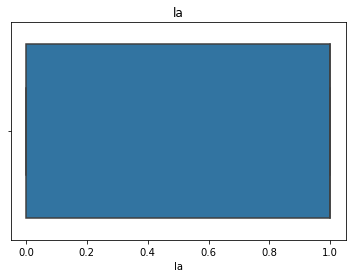

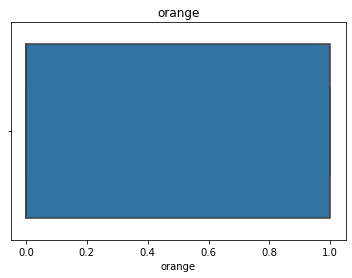

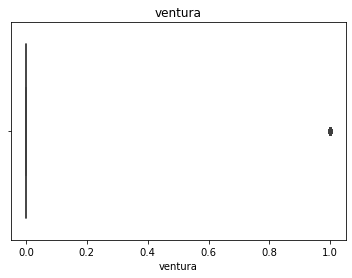

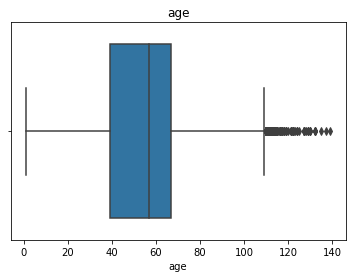

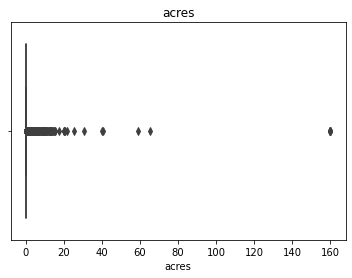

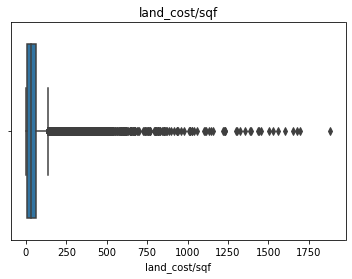

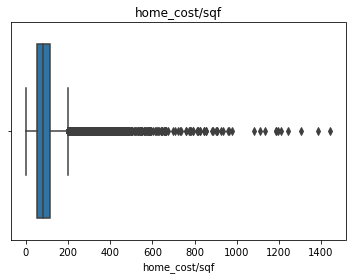

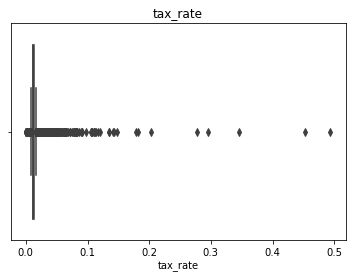

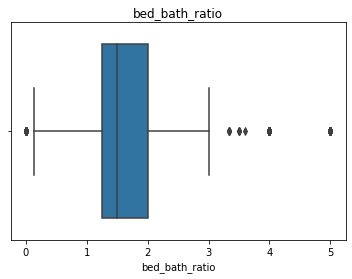

In [11]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()


In [12]:
def remove_outliers():
    return df[(((df.bath <= 7)&(df.bath > 0)) & ((df.bed <= 7)&(df.bed > 0)) & 
               (df.zip < 100000) & 
               (df.acres < 20) &
               (df.sq_feet < 10000) & 
               (df.tax_rate < 10)
              )]
df = remove_outliers()

In [13]:
train, validate = train_test_split(df,random_state=123)
train, test = train_test_split(train, random_state=123)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28455 entries, 10557 to 24976
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcelid        28455 non-null  int64  
 1   logerror        28455 non-null  float64
 2   bed             28455 non-null  float64
 3   bath            28455 non-null  float64
 4   sq_feet         28455 non-null  float64
 5   latitude        28455 non-null  float64
 6   longitude       28455 non-null  float64
 7   lot_size        28455 non-null  float64
 8   city_id         28455 non-null  float64
 9   zip             28455 non-null  float64
 10  year            28455 non-null  float64
 11  home_value      28455 non-null  float64
 12  land_value      28455 non-null  float64
 13  la              28455 non-null  uint8  
 14  orange          28455 non-null  uint8  
 15  ventura         28455 non-null  uint8  
 16  age             28455 non-null  float64
 17  acres           28455 non-n

In [15]:
train.city_id.value_counts()

12447.0    6295
5534.0     1010
40227.0     835
46298.0     779
16764.0     614
           ... 
53162.0       2
36078.0       1
32927.0       1
14906.0       1
21395.0       1
Name: city_id, Length: 173, dtype: int64

In [16]:
#sns.pairplot(data=train.drop(columns=['parcelid','bed','bath','la','orange','ventura','lot_size'
                                      #,'age','year']), hue='zip',corner=True, palette='colorblind')

In [17]:
train = train.drop(columns=['parcelid','bed','bath','year','lot_size'])
validate = validate.drop(columns=['parcelid','bed','bath','year','lot_size'])
test = test.drop(columns=['parcelid','bed','bath','year','lot_size'])

In [18]:
scaler = MinMaxScaler()
scaler.fit(train[continuous])

def scale_and_concat(df):
    scaled_column_names = ['scaled_' + i for i in continuous]
    scaled_array = scaler.transform(df[continuous])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)




In [19]:
train_scaled=scale_and_concat(train)
validate_scaled = scale_and_concat(validate)
test_scaled = scale_and_concat(test)

In [20]:
train_scaled = train_scaled.drop(columns=continuous)
validate_scaled = validate_scaled.drop(columns=continuous)
test_scaled = test_scaled.drop(columns=continuous)




with a p score of 0.0 and a correlation of -0.28 means that we can confidently say that the variables are correlated.
we cannot be confident that the variables are correlated. (1.0957288948924923e-26, 0.06333002522288043)


<AxesSubplot:xlabel='scaled_longitude', ylabel='scaled_land_cost/sqf'>

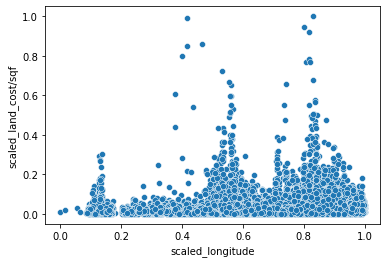

In [21]:
# do latitude, and longitude have a dependent relationship with land cost?
corr, p = stats.pearsonr(train_scaled.scaled_latitude, train_scaled['scaled_land_cost/sqf'])

if p < .05 and (corr > .25 or corr < -.25):
    print(f'with a p score of {p} and a correlation of {corr:.2} means that we can confidently say that the variables are correlated.')
else:
    print(f'we cannot be confident that the variables are correlated. {p,corr}')
    
corr, p = stats.pearsonr(train_scaled.scaled_longitude, train_scaled['scaled_land_cost/sqf'])


if p < .05 and (corr > .25 or corr < -.25):
    print(f'a p score of {p} and a correlation of {corr:.2} means that we can confidently say that the variables are correlated.')
else:
    print(f'we cannot be confident that the variables are correlated. {p,corr}')
    
sns.scatterplot(data=train_scaled, x='scaled_longitude',y='scaled_land_cost/sqf')

# although the statistical test didnt show a strong linear correlation between latitude and land cost,
# there does appear to be a non_linear relationship. clustering may be needed.

<AxesSubplot:xlabel='scaled_latitude', ylabel='scaled_land_cost/sqf'>

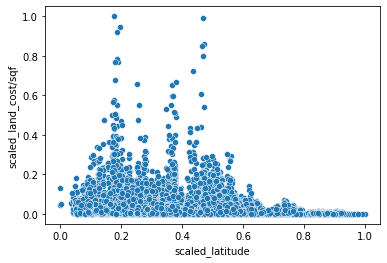

In [22]:
sns.scatterplot(data=train_scaled, x='scaled_latitude',y='scaled_land_cost/sqf')

<AxesSubplot:xlabel='scaled_longitude', ylabel='scaled_latitude'>

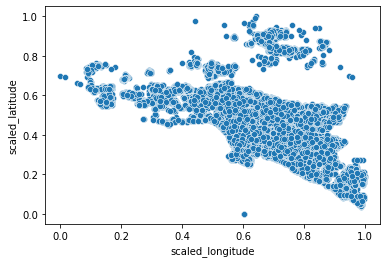

In [23]:
sns.scatterplot(data=train_scaled, x='scaled_longitude',y='scaled_latitude')

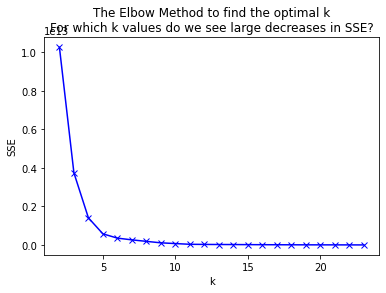

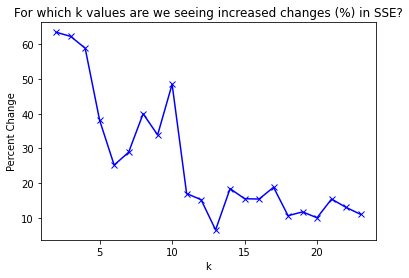

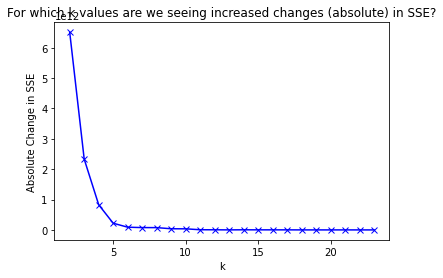

In [24]:
cluster_vars=['scaled_latitude','scaled_longitude','city_id']
cluster_name = 'area_cost'
k_range = range(2,25)

def find_k(train_scaled, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(train_scaled[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

find_k(train_scaled,cluster_vars,k_range)   


In [25]:
kmeans = KMeans(n_clusters = 5, random_state=123)
kmeans.fit(train_scaled[cluster_vars])
train_scaled["location"] = kmeans.predict(train_scaled[cluster_vars])
validate_scaled["location"] = kmeans.predict(validate_scaled[cluster_vars])
test_scaled["location"] = kmeans.predict(test_scaled[cluster_vars])

train_scaled.head()

,logerror,city_id,zip,la,orange,ventura,age,bed_bath_ratio,scaled_sq_feet,scaled_latitude,scaled_longitude,scaled_home_value,scaled_land_value,scaled_acres,scaled_land_cost/sqf,scaled_home_cost/sqf,scaled_tax_rate,location
10557,0.054257,25218.0,96965.0,0,1,0,44.0,2.0,0.107435,0.249150,0.781965,0.012112,0.017213,0.002176,0.094047,0.049139,0.021677,4
35333,0.770198,26483.0,96197.0,1,0,0,68.0,3.0,0.098824,0.429039,0.728509,0.006883,0.001114,0.006362,0.002453,0.029766,0.037188,4
497,0.041260,47198.0,97109.0,0,0,1,58.0,1.5,0.075824,0.549227,0.149507,0.006030,0.000909,0.006336,0.002011,0.031538,0.024772,0
24422,0.053237,54299.0,96296.0,1,0,0,92.0,1.5,0.306238,0.518729,0.704330,0.042992,0.060799,0.016484,0.054385,0.072490,0.022829,0
49677,0.015374,32616.0,96113.0,1,0,0,68.0,1.5,0.110061,0.400897,0.678037,0.017637,0.010541,0.007829,0.019090,0.070224,0.026627,4


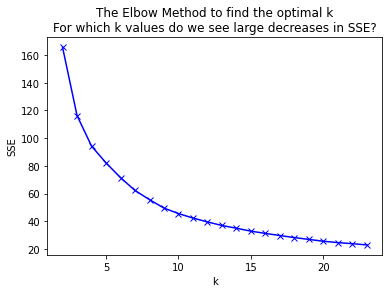

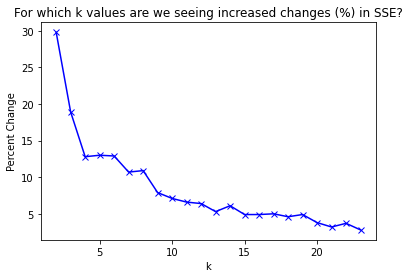

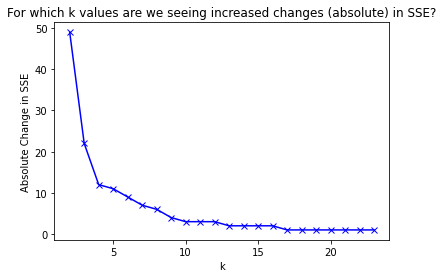

In [26]:
cluster_vars=['scaled_sq_feet','scaled_acres','scaled_home_cost/sqf']
cluster_name = 'area_cost'
k_range = range(2,25)

find_k(train_scaled,cluster_vars,k_range)   

In [27]:
kmeans = KMeans(n_clusters = 7, random_state=123)
kmeans.fit(train_scaled[cluster_vars])
train_scaled["area_home_cost"] = kmeans.predict(train_scaled[cluster_vars])
validate_scaled["area_home_cost"] = kmeans.predict(validate_scaled[cluster_vars])
test_scaled["area_home_cost"] = kmeans.predict(test_scaled[cluster_vars])

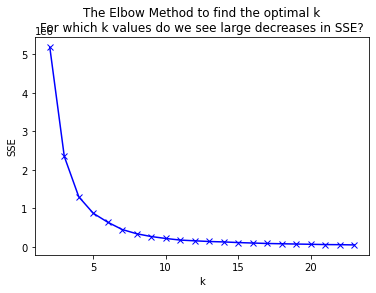

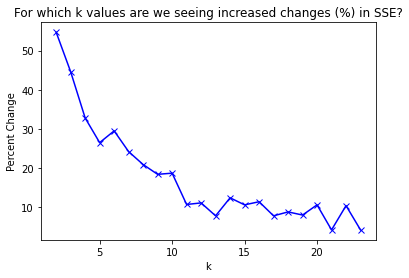

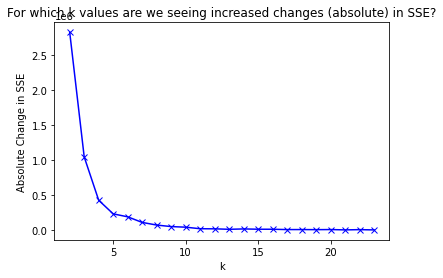

In [28]:
cluster_vars=['age','bed_bath_ratio','scaled_home_cost/sqf']
cluster_name = 'area_cost'
k_range = range(2,25)

find_k(train_scaled,cluster_vars,k_range)   

In [29]:
kmeans = KMeans(n_clusters = 5, random_state=123)
kmeans.fit(train_scaled[cluster_vars])
train_scaled["age_bed_cost"] = kmeans.predict(train_scaled[cluster_vars])
validate_scaled["age_bed_cost"] = kmeans.predict(validate_scaled[cluster_vars])
test_scaled["age_bed_cost"] = kmeans.predict(test_scaled[cluster_vars])

In [30]:
train_scaled.head().T

,10557,35333,497,24422,49677
logerror,0.054257,0.770198,0.041260,0.053237,0.015374
city_id,25218.000000,26483.000000,47198.000000,54299.000000,32616.000000
zip,96965.000000,96197.000000,97109.000000,96296.000000,96113.000000
la,0.000000,1.000000,0.000000,1.000000,1.000000
orange,1.000000,0.000000,0.000000,0.000000,0.000000
ventura,0.000000,0.000000,1.000000,0.000000,0.000000
age,44.000000,68.000000,58.000000,92.000000,68.000000
bed_bath_ratio,2.000000,3.000000,1.500000,1.500000,1.500000
scaled_sq_feet,0.107435,0.098824,0.075824,0.306238,0.110061
scaled_latitude,0.249150,0.429039,0.549227,0.518729,0.400897


In [31]:
x_train_scaled = train_scaled.drop(columns='logerror')
y_train_scaled = pd.DataFrame(train_scaled.logerror)

x_validate_scaled = validate_scaled.drop(columns='logerror')
y_validate_scaled = pd.DataFrame(validate_scaled.logerror)

x_test_scaled = test_scaled.drop(columns='logerror')
y_test_scaled = pd.DataFrame(test_scaled.logerror)

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=18)

# find the top 8 X's correlated with y
f_selector.fit(x_train_scaled, y_train_scaled)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

['city_id',
 'zip',
 'la',
 'orange',
 'ventura',
 'age',
 'scaled_sq_feet',
 'scaled_latitude',
 'scaled_longitude',
 'scaled_home_value',
 'scaled_land_value',
 'scaled_acres',
 'scaled_land_cost/sqf',
 'scaled_home_cost/sqf',
 'scaled_tax_rate',
 'location',
 'area_home_cost',
 'age_bed_cost']

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=18)

# fit the data using RFE
rfe.fit(x_train_scaled,y_train_scaled)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['zip',
 'la',
 'orange',
 'ventura',
 'age',
 'bed_bath_ratio',
 'scaled_sq_feet',
 'scaled_latitude',
 'scaled_longitude',
 'scaled_home_value',
 'scaled_land_value',
 'scaled_acres',
 'scaled_land_cost/sqf',
 'scaled_home_cost/sqf',
 'scaled_tax_rate',
 'location',
 'area_home_cost',
 'age_bed_cost']

Text(0.5, 1.0, 'Do clusters show relationship?')

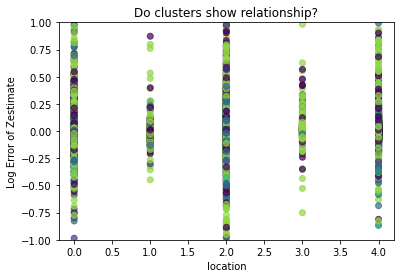

In [34]:


plt.scatter(y=y_train_scaled.logerror, x=x_train_scaled.location, c=x_train_scaled.area_home_cost, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('location')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters show relationship?")


In [35]:
y_train_scaled.logerror.mean()

0.01790111562134987

In [36]:
def get_dummies(df,dummy_vars):
    for i in dummy_vars:
        dummies = pd.get_dummies(df[i],drop_first=True)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(columns=i)

In [37]:
dummy_vars = ['area_home_cost','area_land_cost']

In [38]:
y_train_scaled['baseline'] = y_train_scaled.logerror.mean()
y_validate_scaled['baseline'] = y_train_scaled.logerror.mean()
y_test_scaled['baseline'] = y_train_scaled.logerror.mean()


In [39]:

rmse_train_baseline = mean_squared_error(y_train_scaled.logerror, y_train_scaled.baseline)**(1/2)
rmse_validate_baseline = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.baseline)**(1/2)
rmse_test_baseline = mean_squared_error(y_test_scaled.logerror, y_test_scaled.baseline)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train_baseline, 
      "\nValidate/Out-of-Sample: ", rmse_validate_baseline,
      "\nTest/Out-of-Sample: ", rmse_test_baseline)

RMSE using Mean
Train/In-Sample:  0.16690221961201632 
Validate/Out-of-Sample:  0.1714646972037276 
Test/Out-of-Sample:  0.1965547402621701


In [40]:

lm = LinearRegression(normalize=True)
lm.fit(x_train_scaled, y_train_scaled.logerror)

y_train_scaled['pred'] = lm.predict(x_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.logerror, y_train_scaled.pred)**(1/2)

y_validate_scaled['pred'] = lm.predict(x_validate_scaled)

rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  0.16634897025015705 
Validation/Out-of-Sample:  0.17140479010059637


In [41]:
y_test_scaled['pred'] = lm.predict(x_test_scaled)

rmse_test = mean_squared_error(y_test_scaled.logerror, y_test_scaled.pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTest/In-Sample: ", rmse_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.19613938610782777


In [42]:
baseline_total_rmse=rmse_train_baseline+rmse_validate_baseline+rmse_test_baseline
model_total_rmse = rmse_train+rmse_validate+rmse_test

final_pct= (baseline_total_rmse - model_total_rmse)/baseline_total_rmse
print(final_pct)
print(f'The linear model performed {final_pct:.2%} better than the baseline when predicting log error.')


0.0019227313116302513
The final model performed 0.19% better than the baseline when predicting log error.


In [46]:
kr = KernelRidge()
kr.fit(x_train_scaled, y_train_scaled.logerror)

y_train_scaled['pred'] = kr.predict(x_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.logerror, y_train_scaled.pred)**(1/2)

y_validate_scaled['pred'] = kr.predict(x_validate_scaled)

rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.pred)**(1/2)

y_test_scaled['pred'] = kr.predict(x_test_scaled)

rmse_test = mean_squared_error(y_test_scaled.logerror, y_test_scaled.pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16635997910980616 
Validation/Out-of-Sample:  0.17139837567161015 
Test/Out-of-Sample:  0.19613072184034125
